<a href="https://colab.research.google.com/github/ernesto-miguez/Machine-Learning-training/blob/master/Bayesian_Networks_genetic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Titulo trabajo fin de grado**: Aplicación de Redes Bayesianas a datos genéticos

**Autor**: Álvaro Beltrán Camacho

Fecha: 03/07/2021

# Definición de la estructura del código

En este cuaderno, se incluye el código necesario para la reación de la red Bayesiana (RB) a partir de la base de datos [Molecular Biology (Splice-junction Gene Sequences) Data Set](https://archive.ics.uci.edu/ml/datasets/Molecular+Biology+(Splice-junction+Gene+Sequences)). Para ello, se divide el cuaderno en los siguientes apartados.



1.   Instalación de los paquetes necesarios 
2.   Red Bayesiana
  1. Explicación y análisis previo de los datos.
  2. Cargar los datos.
  3. Limpieza de los datos
      1. Eliminar datos irrelevantes
      2. Selección de variables.
  4. División de conjuntos.
  5. Aprendizaje estructura.
  6. Aprendizaje distribución.
  7. Predicción.
3.   Representar red Bayesiana interactiva 



## Arquitectura del código


Es un cuaderno híbrido entre los lenguajes Python y R. Para hacer que esto sea viable, se ha usado la librería [rpy2](https://rpy2.github.io/). Con esta librería se consigue ejecutar código R embebido en un proceso de Python. Esta decisión se ha tomado porque la librería que se va a usar para el aprendizaje de la RB no está optimizada en Python y no tiene incluidas todas las funciones. Además, se querían poder usar librerías de Python como [Pandas](https://pandas.pydata.org/) y [scikit-learn](https://scikit-learn.org/stable/) para el preprocesado de los datos. Por último, para facilitar la integración de todos los paquetes y herramientas de cara a poder ser ejecutado por otro usuario fácilmente; se integró toda esta arquitectura en la nube de google mediante los cuadernos de Python Google Colab. La estructura final queda de la siguiente forma:


![](https://drive.google.com/uc?export=view&id=1G6mU_o8x4wYFRaSesKQi4-GTA-QDiRLf)


## Integración de R en Python

Como se ha comentado, se usa el paquete [rpy2](https://rpy2.github.io/). Lo primero que se hace es actualizar la extensión de python rpy2.

```
%reload_ext  rpy2.ipython 
```

Para ejecutar código R en Python una ejecutada la sentencia anterior, se debe usar al inicio de cada celda la directiva *%%R*.Las sentencias básicas que hay que conocer, son aquellas que permiten el flujo de datos entre Python y el sistema embebido que ejecuta R. Estas sentencias son:

```
%R -o df1 -o df2 # transfiere df1 de R a Python en df2
%R -i df1 -i df2 # transfiere df1 de Python a R en df2

```

En la siguiente sección, se instalan los paquetes necesarios que se van a necesitar en R.



# Instalación paquetes necesarios

Como ya se ha comentado, lo primero es recargar el paquete rpy2.

In [ ]:
%reload_ext  rpy2.ipython 

Lo segundo, va a ser instalar los paquetes que se van a usar en R; sie stos no se encuentran instalados. Los paquetes son:

*   **BNlearn** para la estimación de la RB a partir de los datos. También se usa para predecir el resultado de una nueva instancia no aprendida por la RB.
*   Los paquetes **graphviz**, **graph** y **grid**. Para visualizar las estructuras de RBs que se generen.



In [ ]:
%%R
a<-installed.packages()
packages<-a[,1] 
if (!is.element("bnlearn", packages)){
  print("No está instalado, instalando bnlearn...")
  install.packages("https://www.bnlearn.com/releases/bnlearn_latest.tar.gz", repos = NULL, type = "source")
}else
  print("BNlearn está instalado...")

if (!is.element("Rgraphviz", packages)){
  print("No está instalado, instalando Rgraphviz...")
  if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

  BiocManager::install("Rgraphviz")
}else
  print("Rgraphviz está instalado...")

if (!is.element("graph", packages)){
  print("No está instalado, instalando graph...")
  if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

  BiocManager::install("graph")

}else
  print("graph está instalado...")

if (!is.element("grid", packages)){
  print("No está instalado, instalando grid...")
  install.packages("grid")

}else
  print("grid está instalado...")




# Red Bayesiana

## Explicación y análisis previo de los datos



La base de datos [Molecular Biology (Splice-junction Gene Sequences) Data Set](https://archive.ics.uci.edu/ml/datasets/Molecular+Biology+(Splice-junction+Gene+Sequences)) se creó para el estudio de las regiones de empalme (RE), regiones del ADN donde se produce el cambio de Exón a Intrón. Para ello, se tomaron **3190** secuencias de genes de **60** posiciones etiquetadas mediante **3** categorías. Las categorías se definen conforme al tipo de cambio que se produce en la región de empalme. 


* **EI**. Denota que se ha producido en ese gen un cambio de exón a intrón.

* **IE**. Denota que se ha producido en ese gen un cambio de intrón a exón.

* **N**. En el gen no hay región de empalme y por tanto ningún cambio de exón a intrón o viceversa.


Cada una de las posiciones de la secuencia del gen toma ocho posibles valores. La tabla siguiente muestra los posibles valores y su significado.


| Carácter | Significado |   | Carácter | Significado   |
|----------|-------------|---|----------|---------------|
|     A    |   Adenina   |   |     D    |   A o G o T   |
|     G    |   Guanina   |   |     N    | A o G o C o T |
|     T    |    Timina   |   |     S    |     C o G     |
|     C    |   Citosina  |   |     R    |     A o G     |


Cada instancia de la base de datos se compone de tres atributos. El primero de ellos es el **nombre** asociado a la secuencia del gen. El segundo, es la **secuencia** de 60 posiciones del gen. La secuencia viene almacenada como una cadena de caracteres. El último atributo, es la **etiqueta** de la RE. 


|Nombre          |Secuencia            |Etiqueta|
|----------------|---------------------|---|
|ATRINS-DONOR-521| CCAGCTGC...GCCAGTCTG| EI  |      
|1ATRINS-DONOR-905| AGACCCGC...TGCCCCCGC| EI   |      
|BABAPOE-DONOR-30| GAGGTGAA...ACGGGGATG| EI   |          
|BABAPOE-DONOR-867| GGGCTGCG...GTTTTCCCC| EI   |         
|BABAPOE-DONOR-2817| GCTCAGCC...CTTGACCCT| EI   |          

La base de datos se va a estudiar es un problema de clasificación. Para ello, se tratarán cada una de las posiciones de la secuencia como variables predictoras y la variable etiqueta como variable a predecir. Dicho esto, en la figura siguiente se muestra la frecuencia de los valores que toman cada una de las posiciones para observar si hay datos extraños.


![](https://drive.google.com/uc?export=view&id=12sKRLgRzyQvWfdQ7Y2pRLT6r4rouaqAY)



En el gráfico anterior se muestran varios hechos interesantes sobre los datos. En primer lugar, los valores **D, N, S y R** no son relevantes en ninguna de las posiciones; será necesario comprobar si tampoco lo son respecto a las etiquetas. En segundo lugar, la distribución en el resto de valores para cada posición parece ser la misma; excepto, en las posiciones $27$, $28$, $29$, $30$ y $31$, donde se dan algunos valores más que otros. Pero no se aprecian discordancias relevantes.

\\

A continuación, se va a analizar el número de instancias etiquetadas con una determinada categoría. Se va a hacer para comprobar si las categorías están balanceadas o si existe una determinada categoría con más instancias que otra. Para ello, se muestran a continuación una tabla con el número de instancias por categoría.

|        |EI |IE |N   |
|--------|---|---|----|
|Nº Genes|767|768|1655|


Se puede apreciar como existe desbalanceo entre las etiquetas de las instancias. La etiqueta N, representa más de la mitad de las instancias de la base de datos. Mientras que las etiquetas IE y EI, se encuentran balanceadas entre sí. La consecuencia de este problema se va a ver reflejado en los conjuntos de entrenamiento y test. Ya que para su creación, se van a mantener las proporciones.

\\

Por último, para confirmar que las instancias que toman en alguna de sus posiciones los valores D, N, S y R son irrelevantes, se presenta una tabla.


|   | EI (%) | IE (%) | N (%) |   |   | EI (%) | IE (%) | N (%) |
|---|--------------|-----------|----------|---|---|-----------|-----------|----------|
| A | 24,984 | 22,1534 | 20,577 |   | D | 0,001   | 0       | 0,002  |
| G | 25,653  | 31,415  | 22,383 |   | N | 0,01    | 0,01    | 0     |
| T | 24,273  | 21,771  | 26,445 |   | S | 0      | 0       | 0,002  |
| C | 25,077 | 24,561  | 30,588 |   | R | 0       | 0       | 0,002  |



En primer lugar; cabe destacar que los valores A, G, T y C, se distribuyen equitativamente entre las categorías. Sin embargo, la sospecha previamente planteada se confirma. Los valores D, N, S y R también son irrelevantes para discernir sobre las categorías debido a la baja representación que tienen en las instancias. En consecuencia, para facilitar el estudio, se decide eliminar las instancias que tienen los valores mencionados en alguna de sus posiciones.

## Cargar datos

Los datos, se van a cargar desde un fichero CSV alojado en drive. El contenedor de los datos va a ser un DataFrame de la librería [Pandas](https://pandas.pydata.org/) . El DataFrame es un tipo de dato de Python en formato tabla, al que se le pueden realizar transformaciones de forma muy sencilla.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?export=view&id=1Bah62Rv3EdGOfl5KYHlOWyVgRplty6FB')


Se muestran los datos leídos. Donde las varibles son: *class*, *Name*, *Sequence*. La variable *class* es la variable a predecir o la variable a la que llamaré etiqueta.

In [ ]:
df

,class,Name,Sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...
...,...,...,...
3185,N,ORAHBPSBD-NEG-2881,TCTCTTCCCTTCCCCTCTCTCTTTCTTTCTTTT...
3186,N,ORAINVOL-NEG-2161,GAGCTCCCAGAGCAGCAAGAGGGCCAGCTGAA...
3187,N,ORARGIT-NEG-241,TCTCGGGGGCGGCCGGCGCGGCGGGGAGCG...
3188,N,TARHBB-NEG-541,ATTCTACTTAGTAAACATAATTTCTTGTG...


## Limpieza de los Datos

Como se puede observar, la secuencia de cada gen leída es una cadena de caracteres . El formato deseado es una variable por posición del gen. Además, el nombre del gen no aporta ninguna información.


Por tanto, habrá que hacer una serie de transformaciones. Para ello, se define una nueva tabla (o DataFrame) llamada data. Y se hacen tres cosas:

1. Añadir la columna de las etiquetas
2. Eliminar el espacio en blanco al inicio de la cadena para cada secuencia; almacenando todas las secuencias en una matriz.
3. Añadir cada una de las posiciones a una columna de la tabla data.




In [ ]:
data = {'class': df['class']} 

datos = pd.DataFrame(data) 

In [ ]:
def remove_values_from_list(the_list, val):
   return [value for value in the_list if value != val]

secuencias = []
for i in range(len(df['Sequence'])):
  secuencias.append(remove_values_from_list(list(df['Sequence'][i]),' '))

for i in range(len(secuencias[0])):
  datos['pos'+str(i)]=np.array(secuencias)[:,i]

Se puede observar que ya está en el formato correcto

In [ ]:
datos

,class,pos0,pos1,pos2,pos3,pos4,pos5,pos6,pos7,pos8,pos9,pos10,pos11,pos12,pos13,pos14,pos15,pos16,pos17,pos18,pos19,pos20,pos21,pos22,pos23,pos24,pos25,pos26,pos27,pos28,pos29,pos30,pos31,pos32,pos33,pos34,pos35,pos36,pos37,pos38,pos39,pos40,pos41,pos42,pos43,pos44,pos45,pos46,pos47,pos48,pos49,pos50,pos51,pos52,pos53,pos54,pos55,pos56,pos57,pos58,pos59
0,EI,C,C,A,G,C,T,G,C,A,T,C,A,C,A,G,G,A,G,G,C,C,A,G,C,G,A,G,C,A,G,G,T,C,T,G,T,T,C,C,A,A,G,G,G,C,C,T,T,C,G,A,G,C,C,A,G,T,C,T,G
1,EI,A,G,A,C,C,C,G,C,C,G,G,G,A,G,G,C,G,G,A,G,G,A,C,C,T,G,C,A,G,G,G,T,G,A,G,C,C,C,C,A,C,C,G,C,C,C,C,T,C,C,G,T,G,C,C,C,C,C,G,C
2,EI,G,A,G,G,T,G,A,A,G,G,A,C,G,T,C,C,T,T,C,C,C,C,A,G,G,A,G,C,C,G,G,T,G,A,G,A,A,G,C,G,C,A,G,T,C,G,G,G,G,G,C,A,C,G,G,G,G,A,T,G
3,EI,G,G,G,C,T,G,C,G,T,T,G,C,T,G,G,T,C,A,C,A,T,T,C,C,T,G,G,C,A,G,G,T,A,T,G,G,G,G,C,G,G,G,G,C,T,T,G,C,T,C,G,G,T,T,T,T,C,C,C,C
4,EI,G,C,T,C,A,G,C,C,C,C,C,A,G,G,T,C,A,C,C,C,A,G,G,A,A,C,T,G,A,C,G,T,G,A,G,T,G,T,C,C,C,C,A,T,C,C,C,G,G,C,C,C,T,T,G,A,C,C,C,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,N,T,C,T,C,T,T,C,C,C,T,T,C,C,C,C,T,C,T,C,T,C,T,T,T,C,T,T,T,C,T,T,T,T,C,T,C,T,C,C,T,C,T,T,C,T,C,T,T,C,T,T,T,C,C,T,C,T,C,T,T
3186,N,G,A,G,C,T,C,C,C,A,G,A,G,C,A,G,C,A,A,G,A,G,G,G,C,C,A,G,C,T,G,A,A,G,C,A,C,C,T,G,G,A,G,A,A,G,C,A,G,G,A,G,G,C,A,C,A,G,C,T,G
3187,N,T,C,T,C,G,G,G,G,G,C,G,G,C,C,G,G,C,G,C,G,G,C,G,G,G,G,A,G,C,G,G,T,C,C,C,C,G,G,C,C,G,C,G,G,C,C,C,C,G,A,C,G,T,G,T,G,T,G,T,C
3188,N,A,T,T,C,T,A,C,T,T,A,G,T,A,A,A,C,A,T,A,A,T,T,T,C,T,T,G,T,G,C,T,A,G,A,T,A,A,C,C,A,A,A,T,T,A,A,G,A,A,A,A,C,C,A,A,A,A,C,A,A


### Eliminar datos irrelevantes

A continuación, se van a eliminar las intancias con los valores D, N, R y S como ya se ha comentado en una sección anterior.

In [ ]:
for i in datos.columns:
  if i!='class':
    datos = datos[datos[i] != 'N']
    datos = datos[datos[i] != 'R']
    datos = datos[datos[i] != 'S']
    datos = datos[datos[i] != 'D']

In [ ]:
for i in datos.columns:
  print(pd.unique(datos[i]))

['EI' 'IE' 'N']
['C' 'A' 'G' 'T']
['C' 'G' 'A' 'T']
['A' 'G' 'T' 'C']
['G' 'C' 'A' 'T']
['C' 'T' 'A' 'G']
['T' 'C' 'G' 'A']
['G' 'A' 'C' 'T']
['C' 'A' 'G' 'T']
['A' 'C' 'G' 'T']
['T' 'G' 'C' 'A']
['C' 'G' 'A' 'T']
['A' 'G' 'C' 'T']
['C' 'A' 'G' 'T']
['A' 'G' 'T' 'C']
['G' 'C' 'T' 'A']
['G' 'C' 'T' 'A']
['A' 'G' 'T' 'C']
['G' 'T' 'A' 'C']
['G' 'A' 'C' 'T']
['C' 'G' 'A' 'T']
['C' 'G' 'T' 'A']
['A' 'C' 'T' 'G']
['G' 'C' 'A' 'T']
['C' 'G' 'A' 'T']
['G' 'T' 'A' 'C']
['A' 'G' 'C' 'T']
['G' 'C' 'T' 'A']
['C' 'A' 'G' 'T']
['A' 'G' 'C' 'T']
['G' 'C' 'A' 'T']
['G' 'C' 'T' 'A']
['T' 'C' 'G' 'A']
['C' 'G' 'A' 'T']
['T' 'A' 'C' 'G']
['G' 'T' 'A' 'C']
['T' 'C' 'A' 'G']
['T' 'C' 'A' 'G']
['C' 'G' 'T' 'A']
['C' 'G' 'T' 'A']
['A' 'G' 'C' 'T']
['A' 'C' 'G' 'T']
['G' 'C' 'A' 'T']
['G' 'A' 'C' 'T']
['G' 'C' 'T' 'A']
['C' 'T' 'A' 'G']
['C' 'G' 'T' 'A']
['T' 'C' 'G' 'A']
['T' 'G' 'C' 'A']
['C' 'G' 'T' 'A']
['G' 'C' 'A' 'T']
['A' 'G' 'C' 'T']
['G' 'T' 'A' 'C']
['C' 'G' 'T' 'A']
['C' 'G' 'T' 'A']
['A' 'C' 'G'

In [ ]:
datos.describe()

,class,pos0,pos1,pos2,pos3,pos4,pos5,pos6,pos7,pos8,pos9,pos10,pos11,pos12,pos13,pos14,pos15,pos16,pos17,pos18,pos19,pos20,pos21,pos22,pos23,pos24,pos25,pos26,pos27,pos28,pos29,pos30,pos31,pos32,pos33,pos34,pos35,pos36,pos37,pos38,pos39,pos40,pos41,pos42,pos43,pos44,pos45,pos46,pos47,pos48,pos49,pos50,pos51,pos52,pos53,pos54,pos55,pos56,pos57,pos58,pos59
count,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175,3175
unique,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
top,N,G,C,C,C,C,C,C,C,C,T,T,C,C,C,C,C,T,T,C,T,C,C,C,C,C,T,C,C,A,G,G,T,A,A,G,T,G,C,C,G,G,G,G,C,C,G,G,G,G,G,G,G,G,G,G,G,G,C,C,G
freq,1648,874,854,873,882,857,890,852,876,904,844,867,925,873,893,955,942,907,903,919,933,936,918,962,949,944,968,880,1302,1606,1814,1582,1424,979,1114,1197,927,966,862,875,924,911,915,904,837,882,869,909,909,944,834,899,869,872,931,855,835,904,865,856,949


Se puede observar que ya no existen instancias con los valores mencionados. Se han eliminado un total de **15** intancias.

### Selección de variables



En esta base de datos nos encontramos ante una gran cantidad de variables predictoras; por tanto, es necesario realizar tests estadísticos para estudiar la posibilidad de eliminar variables irrelevantes.

Para aplicar los test estadísticos, se necesitan separar las etiquetas de los datos e indicar que los datos son categóricos. 

In [ ]:

y=pd.DataFrame(datos['class'],columns=['class'])
X=datos.drop(columns=['class'])

for i in X.columns:
  X[i].astype('category')


**Codificar valores**

Para el test de dependencia Chi2, hay que codificar las variables de caracteres a enteros. La codificación se hará mediante una función de la librería Scikit-Learn llamada [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Además, se debe añadir la información de que las variables siguen siendo categóricas. La codificación es la siguiente: 

| |Codificacion|
|-|------------|
|A|      0     |
|C|      1     |
|G|      2     |
|T|      3     |

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X_encoder=X.copy()

for i in X_encoder.columns:
  X_encoder[i] = le.fit_transform(X_encoder[[i]])
  X_encoder[i] = X_encoder[i].astype('category')

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


A continuación, se muestra la tabla codificada.

In [ ]:
X_encoder

,pos0,pos1,pos2,pos3,pos4,pos5,pos6,pos7,pos8,pos9,pos10,pos11,pos12,pos13,pos14,pos15,pos16,pos17,pos18,pos19,pos20,pos21,pos22,pos23,pos24,pos25,pos26,pos27,pos28,pos29,pos30,pos31,pos32,pos33,pos34,pos35,pos36,pos37,pos38,pos39,pos40,pos41,pos42,pos43,pos44,pos45,pos46,pos47,pos48,pos49,pos50,pos51,pos52,pos53,pos54,pos55,pos56,pos57,pos58,pos59
0,1,1,0,2,1,3,2,1,0,3,1,0,1,0,2,2,0,2,2,1,1,0,2,1,2,0,2,1,0,2,2,3,1,3,2,3,3,1,1,0,0,2,2,2,1,1,3,3,1,2,0,2,1,1,0,2,3,1,3,2
1,0,2,0,1,1,1,2,1,1,2,2,2,0,2,2,1,2,2,0,2,2,0,1,1,3,2,1,0,2,2,2,3,2,0,2,1,1,1,1,0,1,1,2,1,1,1,1,3,1,1,2,3,2,1,1,1,1,1,2,1
2,2,0,2,2,3,2,0,0,2,2,0,1,2,3,1,1,3,3,1,1,1,1,0,2,2,0,2,1,1,2,2,3,2,0,2,0,0,2,1,2,1,0,2,3,1,2,2,2,2,2,1,0,1,2,2,2,2,0,3,2
3,2,2,2,1,3,2,1,2,3,3,2,1,3,2,2,3,1,0,1,0,3,3,1,1,3,2,2,1,0,2,2,3,0,3,2,2,2,2,1,2,2,2,2,1,3,3,2,1,3,1,2,2,3,3,3,3,1,1,1,1
4,2,1,3,1,0,2,1,1,1,1,1,0,2,2,3,1,0,1,1,1,0,2,2,0,0,1,3,2,0,1,2,3,2,0,2,3,2,3,1,1,1,1,0,3,1,1,1,2,2,1,1,1,3,3,2,0,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,3,1,3,1,3,3,1,1,1,3,3,1,1,1,1,3,1,3,1,3,1,3,3,3,1,3,3,3,1,3,3,3,3,1,3,1,3,1,1,3,1,3,3,1,3,1,3,3,1,3,3,3,1,1,3,1,3,1,3,3
3186,2,0,2,1,3,1,1,1,0,2,0,2,1,0,2,1,0,0,2,0,2,2,2,1,1,0,2,1,3,2,0,0,2,1,0,1,1,3,2,2,0,2,0,0,2,1,0,2,2,0,2,2,1,0,1,0,2,1,3,2
3187,3,1,3,1,2,2,2,2,2,1,2,2,1,1,2,2,1,2,1,2,2,1,2,2,2,2,0,2,1,2,2,3,1,1,1,1,2,2,1,1,2,1,2,2,1,1,1,1,2,0,1,2,3,2,3,2,3,2,3,1
3188,0,3,3,1,3,0,1,3,3,0,2,3,0,0,0,1,0,3,0,0,3,3,3,1,3,3,2,3,2,1,3,0,2,0,3,0,0,1,1,0,0,0,3,3,0,0,2,0,0,0,0,1,1,0,0,0,0,1,0,0


**Test $\chi^2$ de independencia**

El test $\chi^2$ de independencia es una técnica estadística para estudiar la dependencia entre variables. Las hipótesis son:

* $H_0$ : Las dos variables estudiadas por el test son independientes.

* $H_1$ : Las variables son dependientes.

El valor que se va a tomar para rechazar la hipótesis nula será $0.05$ .

El test $\chi^2$ de independencia se va a estudiar entre cada una de las variables posiciones y la etiqueta. Ya que, si una variable es independiente de la etiqueta; para el problema de clasificación sobre la etiqueta no es necesaria esa variable.


Para el cálculo del test, se va a usar la implementación propuesta por la librería Scikit-Learn, [sklearn.feature-selection.chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html).

In [ ]:
from sklearn.feature_selection import chi2

chi_scores =chi2(X_encoder, y)

In [ ]:
p_values = pd.Series(chi_scores[1],index = X_encoder.columns)
p_values.sort_values(ascending = False , inplace = True)

A continuación, se presenta la gráfica de los p-valores.

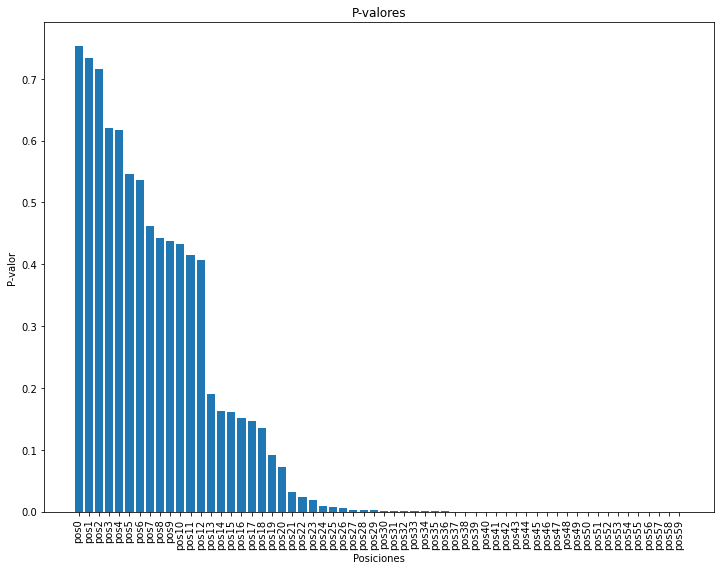

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 9))
langs = X.columns
plt.bar(langs,p_values)
plt.title("P-valores")
plt.xlabel("Posiciones")
plt.ylabel("P-valor")
plt.xticks(rotation=90)
plt.show()

Por tanto, aquellas que tienen un p-valor mayor que $0.05$ se eliminan; ya que son independientes de la etiqueta.

Para ello, se realiza un conteo de las variables que cumplen esta condición y mediante la función de Scikit-Learn [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) se eliminan esas variables.



In [ ]:
THRESHOLD_P_VALUE = 0.05

In [ ]:
num=0
for i in p_values:
  if i > THRESHOLD_P_VALUE:
    num+=1

In [ ]:
num

21

Se quieren eliminar 21 variables; por tanto, se quieren escoger k=39 en el selectKBest.

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

select_k_best_classifier = SelectKBest(chi2, k=39)
X_values=select_k_best_classifier.fit_transform(X_encoder,y)

mask = select_k_best_classifier.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, X_encoder.columns):
    if bool:
        new_features.append(feature)

X_chi = pd.DataFrame(X_values, columns=new_features)

In [ ]:
X_chi

,pos9,pos10,pos11,pos12,pos13,pos14,pos15,pos16,pos17,pos18,pos19,pos20,pos21,pos22,pos23,pos24,pos25,pos27,pos28,pos29,pos30,pos31,pos32,pos33,pos34,pos35,pos39,pos40,pos42,pos44,pos45,pos46,pos48,pos49,pos50,pos53,pos54,pos57,pos59
0,3,1,0,1,0,2,2,0,2,2,1,1,0,2,1,2,0,1,0,2,2,3,1,3,2,3,0,0,2,1,1,3,1,2,0,1,0,1,2
1,2,2,2,0,2,2,1,2,2,0,2,2,0,1,1,3,2,0,2,2,2,3,2,0,2,1,0,1,2,1,1,1,1,1,2,1,1,1,1
2,2,0,1,2,3,1,1,3,3,1,1,1,1,0,2,2,0,1,1,2,2,3,2,0,2,0,2,1,2,1,2,2,2,2,1,2,2,0,2
3,3,2,1,3,2,2,3,1,0,1,0,3,3,1,1,3,2,1,0,2,2,3,0,3,2,2,2,2,2,3,3,2,3,1,2,3,3,1,1
4,1,1,0,2,2,3,1,0,1,1,1,0,2,2,0,0,1,2,0,1,2,3,2,0,2,3,1,1,0,1,1,1,2,1,1,3,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170,3,3,1,1,1,1,3,1,3,1,3,1,3,3,3,1,3,3,1,3,3,3,3,1,3,1,3,1,3,3,1,3,1,3,3,1,3,1,3
3171,2,0,2,1,0,2,1,0,0,2,0,2,2,2,1,1,0,1,3,2,0,0,2,1,0,1,2,0,0,2,1,0,2,0,2,0,1,1,2
3172,1,2,2,1,1,2,2,1,2,1,2,2,1,2,2,2,2,2,1,2,2,3,1,1,1,1,1,2,2,1,1,1,2,0,1,2,3,2,1
3173,0,2,3,0,0,0,1,0,3,0,0,3,3,3,1,3,3,3,2,1,3,0,2,0,3,0,0,0,3,0,0,2,0,0,0,0,0,1,0


**Test de varianzas**

Se va a utilizar el test de varianzas para comprobar que cada una de las variables predictoras toman valores lo suficientemente distintos bajo un determinado umbral. El umbral que se va a tomar será el 10%; para eliminar las variables que varía mínimamente.

Para implentar este test se va a usar la función de Scikit-Learn [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html).

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(0.1)
X_values=selector.fit_transform(X_chi)

mask = selector.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, X_chi.columns):
    if bool:
        new_features.append(feature)

X_var = pd.DataFrame(X_values, columns=new_features)

In [ ]:
X_var

,pos9,pos10,pos11,pos12,pos13,pos14,pos15,pos16,pos17,pos18,pos19,pos20,pos21,pos22,pos23,pos24,pos25,pos27,pos28,pos29,pos30,pos31,pos32,pos33,pos34,pos35,pos39,pos40,pos42,pos44,pos45,pos46,pos48,pos49,pos50,pos53,pos54,pos57,pos59
0,3,1,0,1,0,2,2,0,2,2,1,1,0,2,1,2,0,1,0,2,2,3,1,3,2,3,0,0,2,1,1,3,1,2,0,1,0,1,2
1,2,2,2,0,2,2,1,2,2,0,2,2,0,1,1,3,2,0,2,2,2,3,2,0,2,1,0,1,2,1,1,1,1,1,2,1,1,1,1
2,2,0,1,2,3,1,1,3,3,1,1,1,1,0,2,2,0,1,1,2,2,3,2,0,2,0,2,1,2,1,2,2,2,2,1,2,2,0,2
3,3,2,1,3,2,2,3,1,0,1,0,3,3,1,1,3,2,1,0,2,2,3,0,3,2,2,2,2,2,3,3,2,3,1,2,3,3,1,1
4,1,1,0,2,2,3,1,0,1,1,1,0,2,2,0,0,1,2,0,1,2,3,2,0,2,3,1,1,0,1,1,1,2,1,1,3,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170,3,3,1,1,1,1,3,1,3,1,3,1,3,3,3,1,3,3,1,3,3,3,3,1,3,1,3,1,3,3,1,3,1,3,3,1,3,1,3
3171,2,0,2,1,0,2,1,0,0,2,0,2,2,2,1,1,0,1,3,2,0,0,2,1,0,1,2,0,0,2,1,0,2,0,2,0,1,1,2
3172,1,2,2,1,1,2,2,1,2,1,2,2,1,2,2,2,2,2,1,2,2,3,1,1,1,1,1,2,2,1,1,1,2,0,1,2,3,2,1
3173,0,2,3,0,0,0,1,0,3,0,0,3,3,3,1,3,3,3,2,1,3,0,2,0,3,0,0,0,3,0,0,2,0,0,0,0,0,1,0


Se observa que el test de varianzas no elimina ninguna variable.

## División de conjuntos







El conjunto de datos, se va a dividir en **3** partes. Una parte para el conjunto de entramiento , train, con el que se estimará tanto la estructura como los parámetros de la distribución. Uno para validación ,val , con el que se elegirá la mejor estructura. Y otro conjunto para comprobar, test, para evaluar finalmente la bondad del modelo frente a la clasificación de las etiquetas. Para facilitar la comprensión de la división del conjunto se aporta la siguiente imagen:

\\

![](https://drive.google.com/uc?export=view&id=1J96x0nsixPep1o8CC9wJAPd_zQ5-_f6I)

\\

El conjunto se va a dividir teniendo en cuenta que se quiere mantener la proporción de las etiquetas a predecir.


Para implemtar esta partición del conjunto se usa la función de Scikit-Learn [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Los parámetros son:

* *X*. Variables predictoras del conjunto a particionar.
* *y*. Variable a predecir.
* *test_size*. Porcentaje del conjunto de test.
* *random_state*. Semilla para el generador de números aleatorios; ya que, la función hace un shuffle de los datos.
* *stratify*. Parámetro para mantener la proporción. Se iguala a la variable "*y*" para mantener la proporción sobre las etiquetas.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=1,stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,stratify=y_train)

In [ ]:
X_train.shape

(1905, 60)

In [ ]:
X_test.shape

(635, 60)

In [ ]:
X_val.shape

(635, 60)

In [ ]:
print(y_train['class'].value_counts())
print(y_test['class'].value_counts())
print(y_val['class'].value_counts())

N     988
IE    459
EI    458
Name: class, dtype: int64
N     330
IE    153
EI    152
Name: class, dtype: int64
N     330
IE    153
EI    152
Name: class, dtype: int64


Se puede apreciar, que las dimensiones y proporciones obtenidas son correctas.

### Reunir datos

Para estimar las estructuras, es necesario reunificar los conjuntos de las etiquetas y las variables predictoras en uno solo; ya que, la librería BNlearn lo usa así.

In [ ]:
train = pd.DataFrame(X_train)
train['class']=y_train['class'].to_numpy()
cols = [train.columns[-1]] + [col for col in train if col != train.columns[-1]]
train=train[cols] #pongo primero la clase

In [ ]:
test = pd.DataFrame(X_test)
test['class']=y_test['class'].to_numpy()
cols = [test.columns[-1]] + [col for col in test if col != test.columns[-1]]
test=test[cols] #pongo primero la clase

In [ ]:
val = pd.DataFrame(X_val)
val['class']=y_val['class'].to_numpy()
cols = [val.columns[-1]] + [col for col in val if col != val.columns[-1]]
val=val[cols] #pongo primero la clase

## Aprendizaje estructura

Como ya se ha explicado en la arquitectura del cuaderno, la parte de estimación se hace en el lenguaje R. Para ello, lo primero que se va a hacer es fijar la semilla para la reproductividad de los datos; además de transferir las estructuras de datos de Python, al sistema embebido R. También se introduce la librería de BNlearn, previamente instalada.

In [ ]:
%%R

library(bnlearn)

set.seed(0)

In [ ]:
%R -i train -i train #transferimos datos a R
%R -i test -i test #transferimos datos a R
%R -i val -i test #transferimos datos a R

La siguiente tarea antes de poder estimar la estructura, es definir que los datos son de tipo factor; es decir, que los datos son categóricos. Además, se muestra para cada uno de los conjuntos, que la estructura de los datos en la transferencia a R ha sido correcta.

In [ ]:
%%R

for (i in colnames(train)){
  train[[i]] <- as.factor(train[[i]])
}

summary(train)

 class    pos0    pos1    pos2    pos3    pos4    pos5    pos6    pos7   
 EI:458   A:437   A:460   A:432   A:425   A:486   A:437   A:464   A:456  
 IE:459   C:523   C:512   C:531   C:533   C:540   C:542   C:502   C:538  
 N :988   G:506   G:479   G:512   G:495   G:415   G:459   G:472   G:448  
          T:439   T:454   T:430   T:452   T:464   T:467   T:467   T:463  
 pos8    pos9    pos10   pos11   pos12   pos13   pos14   pos15   pos16  
 A:431   A:456   A:438   A:397   A:453   A:485   A:408   A:410   A:385  
 C:533   C:513   C:506   C:548   C:526   C:540   C:575   C:577   C:566  
 G:451   G:451   G:454   G:491   G:438   G:435   G:458   G:398   G:405  
 T:490   T:485   T:507   T:469   T:488   T:445   T:464   T:520   T:549  
 pos17   pos18   pos19   pos20   pos21   pos22   pos23   pos24   pos25  
 A:374   A:379   A:408   A:389   A:423   A:379   A:380   A:382   A:406  
 C:526   C:548   C:519   C:551   C:560   C:603   C:558   C:566   C:508  
 G:442   G:413   G:410   G:440   G:428   G:408

In [ ]:
%%R

for (i in colnames(test)){
  test[[i]] <- as.factor(test[[i]])
}

summary(test)

 class    pos0    pos1    pos2    pos3    pos4    pos5    pos6    pos7   
 EI:152   A:147   A:160   A:134   A:155   A:169   A:138   A:158   A:174  
 IE:153   C:156   C:163   C:171   C:195   C:147   C:160   C:177   C:160  
 N :330   G:183   G:161   G:160   G:138   G:140   G:184   G:158   G:133  
          T:149   T:151   T:170   T:147   T:179   T:153   T:142   T:168  
 pos8    pos9    pos10   pos11   pos12   pos13   pos14   pos15   pos16  
 A:163   A:159   A:135   A:135   A:137   A:158   A:126   A:143   A:129  
 C:182   C:150   C:154   C:189   C:187   C:191   C:198   C:176   C:161  
 G:149   G:156   G:164   G:166   G:149   G:122   G:147   G:143   G:157  
 T:141   T:170   T:182   T:145   T:162   T:164   T:164   T:173   T:188  
 pos17   pos18   pos19   pos20   pos21   pos22   pos23   pos24   pos25  
 A:142   A:144   A:131   A:120   A:135   A:132   A:132   A:129   A:135  
 C:187   C:189   C:179   C:191   C:177   C:192   C:194   C:194   C:176  
 G:149   G:144   G:133   G:127   G:151   G:152

In [ ]:
%%R

for (i in colnames(val)){
  val[[i]] <- as.factor(val[[i]])
}

summary(val)

 class    pos0    pos1    pos2    pos3    pos4    pos5    pos6    pos7   
 EI:152   A:154   A:155   A:139   A:168   A:145   A:126   A:160   A:155  
 IE:153   C:154   C:179   C:171   C:154   C:170   C:188   C:173   C:178  
 N :330   G:185   G:150   G:167   G:164   G:161   G:182   G:147   G:146  
          T:142   T:151   T:158   T:149   T:159   T:139   T:155   T:156  
 pos8    pos9    pos10   pos11   pos12   pos13   pos14   pos15   pos16  
 A:150   A:148   A:141   A:132   A:145   A:151   A:127   A:144   A:153  
 C:189   C:141   C:159   C:188   C:160   C:162   C:182   C:189   C:177  
 G:147   G:157   G:157   G:144   G:162   G:152   G:158   G:140   G:135  
 T:149   T:189   T:178   T:171   T:168   T:170   T:168   T:162   T:170  
 pos17   pos18   pos19   pos20   pos21   pos22   pos23   pos24   pos25  
 A:131   A:129   A:154   A:130   A:141   A:148   A:123   A:139   A:124  
 C:170   C:182   C:186   C:194   C:181   C:167   C:197   C:184   C:205  
 G:151   G:150   G:122   G:125   G:132   G:139

### Estimación de la estructura de RB

Se van a estudiar algunos algoritmos que aporta [BNlearn Structure Learning](https://www.bnlearn.com/documentation/man/structure.learning.html). Se van a estudiar los algoritmos que usa el artículo *Using Bayesian networks to discover relations between genes, environment, and disease* [1](https://biodatamining.biomedcentral.com/articles/10.1186/1756-0381-6-6):



1.   Grow-Shrink (GS)
2.   Incremental Association (IAMB)
3.   Hill-Climbing (HC)
4.   Max-Min Hill-Climbing (MMHC)

Cada uno de ellos se van a ejecutar sobre el conjunto de entrenamiento (*train*). Además, el algoritmo basado en métricas HC, se va a entrenar con la métrica *Bayesian Information Criterion* (BIC) porque vamos a buscar penalizar las estructuras complejas.







In [ ]:
%%R

hc = hc(train, score="bic")                          
gs = gs(train)              
iamb = iamb(train)            
mmhc = mmhc(train)                      

Ahora se van a comprobar si todos los grafos son dirigidos o existe algún grafo parcialmente dirigido.

In [ ]:
%%R
hc


  Bayesian network learned via Score-based methods

  model:
   [pos0][pos1|pos0][pos2|pos1][pos3|pos2][pos4|pos3][pos5|pos4][pos6|pos5]
   [pos7|pos6][pos8|pos7][pos9|pos8][pos10|pos9][pos11|pos10][pos12|pos11]
   [pos13|pos12][pos14|pos13][class|pos14][pos15|class][pos16|class]
   [pos17|class][pos18|class][pos19|class][pos20|class][pos22|class]
   [pos23|class][pos24|class][pos27|class][pos28|class][pos29|class]
   [pos30|class][pos31|class][pos32|class][pos33|class][pos34|class]
   [pos21|pos20][pos25|class:pos24][pos35|pos34][pos26|pos25][pos36|pos35]
   [pos37|pos36][pos38|pos37][pos39|pos38][pos40|pos39][pos41|pos40]
   [pos42|pos41][pos43|pos42][pos44|pos43][pos45|pos44][pos46|pos45]
   [pos47|pos46][pos48|pos47][pos49|pos48][pos50|pos49][pos51|pos50]
   [pos52|pos51][pos53|pos52][pos54|pos53][pos55|pos54][pos56|pos55]
   [pos57|pos56][pos58|pos57][pos59|pos58]
  nodes:                                 61 
  arcs:                                  61 
    undirected arcs:       

In [ ]:
%%R
mmhc


  Bayesian network learned via Hybrid methods

  model:
   [class][pos0][pos1|pos0][pos28|class][pos29|class][pos30|class][pos31|class]
   [pos2|pos1][pos32|pos31][pos3|pos2][pos33|pos32][pos4|pos3][pos34|pos33]
   [pos5|pos4][pos35|pos34][pos6|pos5][pos36|pos35][pos7|pos6][pos37|pos36]
   [pos8|pos7][pos38|pos37][pos9|pos8][pos39|pos38][pos10|pos9][pos40|pos39]
   [pos11|pos10][pos41|pos40][pos12|pos11][pos42|pos41][pos13|pos12]
   [pos43|pos42][pos14|pos13][pos44|pos43][pos15|pos14][pos45|pos44]
   [pos16|pos15][pos46|pos45][pos17|pos16][pos47|pos46][pos18|pos17]
   [pos48|pos47][pos19|pos18][pos49|pos48][pos20|pos19][pos50|pos49]
   [pos21|pos20][pos51|pos50][pos22|pos21][pos52|pos51][pos23|pos22]
   [pos53|pos52][pos24|pos23][pos54|pos53][pos25|pos24][pos55|pos54]
   [pos26|pos25][pos56|pos55][pos27|pos26][pos57|pos56][pos58|pos57]
   [pos59|pos58]
  nodes:                                 61 
  arcs:                                  59 
    undirected arcs:                     0 


In [ ]:
%%R
gs


  Bayesian network learned via Constraint-based methods

  model:
    [partially directed graph]
  nodes:                                 61 
  arcs:                                  5 
    undirected arcs:                     1 
    directed arcs:                       4 
  average markov blanket size:           0.23 
  average neighbourhood size:            0.16 
  average branching factor:              0.066 

  learning algorithm:                    Grow-Shrink 
  conditional independence test:         Mutual Information (disc.) 
  alpha threshold:                       0.05 
  tests used in the learning procedure:  4217 



In [ ]:
%%R
iamb


  Bayesian network learned via Constraint-based methods

  model:
    [partially directed graph]
  nodes:                                 61 
  arcs:                                  65 
    undirected arcs:                     11 
    directed arcs:                       54 
  average markov blanket size:           3.15 
  average neighbourhood size:            2.13 
  average branching factor:              0.89 

  learning algorithm:                    IAMB 
  conditional independence test:         Mutual Information (disc.) 
  alpha threshold:                       0.05 
  tests used in the learning procedure:  18263 



se puede observar que tanto el algoritmo GS como el algoritmo IAMB devuelven grafos parcialmente dirigidos. Esto se debe a que el algoritmo devuelve el grafo representante de la clase (parcialmente dirigido); ya que, en ciertas aristas, el test de independencia no consigue conocer la dirección correcta de la dependencia. Para solucionar esto, se usa la función [cextend](https://www.bnlearn.com/documentation/man/cpdag.html). Con esta función se consigue el grafo consistente de la clase con estructura de RB (grafo dirigido acíclico).

In [ ]:
%%R
gs = cextend(gs)
iamb = cextend(iamb)

In [ ]:
%%R
gs


  Bayesian network learned via Constraint-based methods

  model:
   [class][pos1][pos4][pos5][pos6][pos7][pos8][pos9][pos10][pos11][pos12][pos13]
   [pos14][pos15][pos16][pos17][pos18][pos19][pos20][pos21][pos22][pos23][pos24]
   [pos25][pos26][pos27][pos28][pos29][pos30][pos31][pos32][pos33][pos34][pos35]
   [pos36][pos37][pos38][pos39][pos40][pos41][pos42][pos43][pos44][pos45][pos46]
   [pos47][pos48][pos49][pos50][pos51][pos52][pos53][pos54][pos55][pos56][pos57]
   [pos58][pos59][pos0|class:pos1][pos3|class][pos2|pos1:pos3]
  nodes:                                 61 
  arcs:                                  5 
    undirected arcs:                     0 
    directed arcs:                       5 
  average markov blanket size:           0.23 
  average neighbourhood size:            0.16 
  average branching factor:              0.082 

  learning algorithm:                    Grow-Shrink 
  conditional independence test:         Mutual Information (disc.) 
  alpha threshold:    

In [ ]:
%%R
iamb


  Bayesian network learned via Constraint-based methods

  model:
   [pos1][pos3][pos5][pos8][pos11][pos13][pos15][pos17][pos19][pos22][pos25]
   [pos27][pos30][pos32][pos35][pos37][pos39][pos41][pos43][pos45][pos47][pos49]
   [pos51][pos53][pos56][pos59][class|pos30][pos0|pos1][pos2|pos1:pos3:pos11]
   [pos4|pos3:pos5][pos7|pos8][pos10|pos11][pos12|pos11:pos13:pos19]
   [pos14|pos13:pos15][pos16|pos15:pos17][pos18|pos17:pos19][pos21|pos22]
   [pos24|pos25][pos26|pos25:pos27][pos36|pos35:pos37][pos38|pos37:pos39]
   [pos40|pos39:pos41][pos42|pos41:pos43][pos44|pos43:pos45][pos46|pos45:pos47]
   [pos48|pos47:pos49][pos50|pos49:pos51][pos52|pos51:pos53][pos55|pos56]
   [pos58|pos59][pos6|pos5:pos7][pos9|pos8:pos10:pos11][pos20|pos19:pos21]
   [pos23|pos22:pos24][pos29|class][pos31|class:pos30:pos32][pos34|pos35:pos58]
   [pos54|pos53:pos55][pos57|pos56:pos58][pos28|class:pos29][pos33|pos32:pos34]
  nodes:                                 61 
  arcs:                                  65 
 

Finalmente, se tienen las 4 estructuras de RBs aprendidas por cada uno de los algoritmos.

### Comparar Estructuras



En este punto, se van a comparar las estructuras para ver los resultados obtenidos. Para ello, se va a usar la función [compare](https://www.bnlearn.com/documentation/man/compare.html). Con ella, se pueden comparar las estructuras y usando el paquete graphviz se ven las diferencias visualmente:

Se compara el primero grafo con el segundo grafo.
*   Azul: arcos que no tiene el segundo (*fn*)
*   Rojo: arcos que no tiene el primero (*fp*)

Los *tp* son aquellas aristas que tienen los dos.



**HC con MMHC**

In [ ]:
%%R

compare(hc,mmhc, arcs= FALSE)

$tp
[1] 46

$fp
[1] 13

$fn
[1] 15



Ambas estructuras tienen 46 arístas iguales. Este hecho tiene sentido ya que el algoritmo MMHC usa HC para dirigir sus aristas. A continuación, se muestran dos imágenes; la primera, es la estructura del algoritmo HC; miestras que la segunda, muestra con los colores explicados anteriormente las diferencias.

R[write to console]: Loading required namespace: Rgraphviz



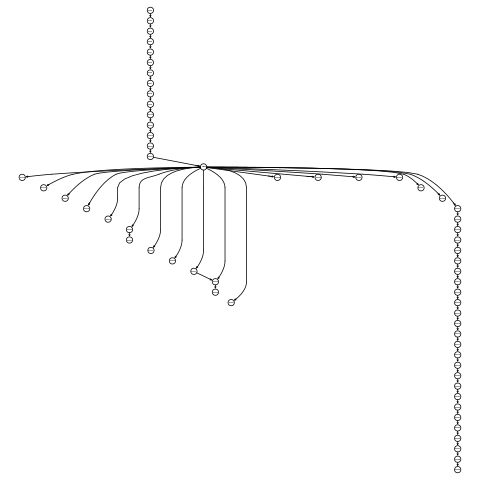

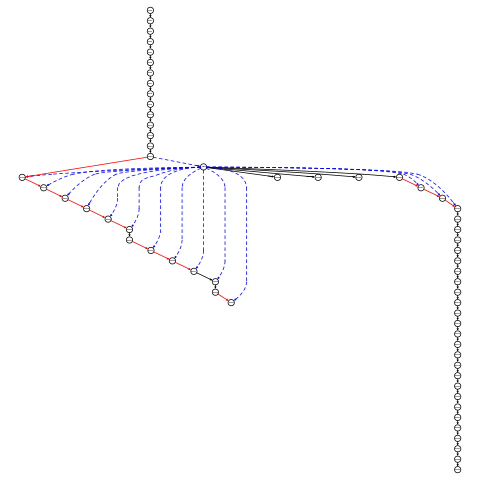

In [ ]:
%%R
graphviz.compare(hc,mmhc)

Realmente, los arcos importantes para el problema de clasificación planteado son los arcos en los que la variable *class* interviene. Para comprobar este hecho se implementa la función *arcos_comunes_Class*. Estos arcos en los que ambos grafos coinciden son los siguientes:

In [ ]:
%%R

arcos_comunes_Class<-function(bn1,bn2){
  arcosComunesClass=compare(bn1,bn2, arcs= TRUE)$tp
  arcosComunesClass[(arcosComunesClass=="class")[,1],]  
}

In [ ]:
%%R

arcos_comunes_Class(hc,mmhc)

     from    to     
[1,] "class" "pos29"
[2,] "class" "pos28"
[3,] "class" "pos30"
[4,] "class" "pos31"


**HC con GS**

In [ ]:
%%R

compare(hc,gs, arcs= FALSE)

$tp
[1] 1

$fp
[1] 4

$fn
[1] 60



Las estructuras que obtienen estos algoritmos, son completamente diferentes excepto en un arco; por lo que no tiene sentido visualizar los grafos. Cabe comprobar si aporta información sobre la variable *class*.

In [ ]:
%%R

arcos_comunes_Class(hc,gs)

     from to


No aporta ningún arco común con *class*.

**HC con IAMB**

In [ ]:
%%R

compare(hc,iamb, arcs= FALSE)

$tp
[1] 21

$fp
[1] 44

$fn
[1] 40



Entre estas dos estructuras si hay más arcos similares. Aunque, como se aprecia visualmente en la imagen, son muy pocos arcos.

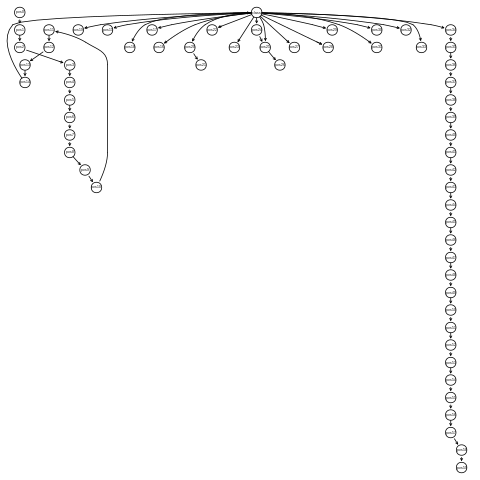

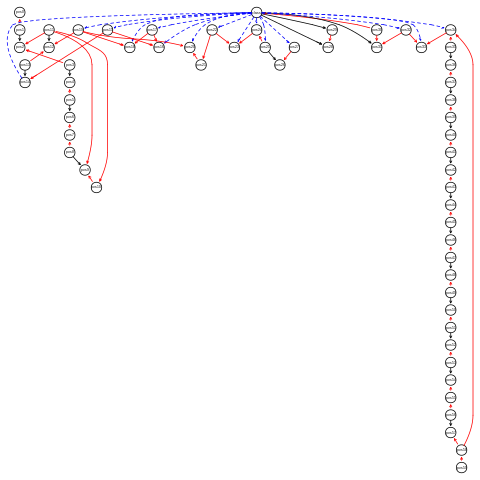

In [ ]:
%%R
graphviz.compare(hc,iamb)

In [ ]:
%%R

arcos_comunes_Class(hc,iamb)

     from    to     
[1,] "class" "pos29"
[2,] "class" "pos28"
[3,] "class" "pos31"


Se observa que vuelven a aparecer esos tres arcos. Por lo que tres de las cuatro estructuras apoyan esa relación de dependencia.

**IAMB con MMHC**

Como las estructuras MMHC y HC son parecidas, se esperan los mismos resultados.

In [ ]:
%%R

compare(iamb,mmhc, arcs= FALSE)

$tp
[1] 26

$fp
[1] 33

$fn
[1] 39



In [ ]:
%%R
arcos_comunes_Class(iamb,mmhc)

     from    to     
[1,] "class" "pos28"
[2,] "class" "pos29"
[3,] "class" "pos31"


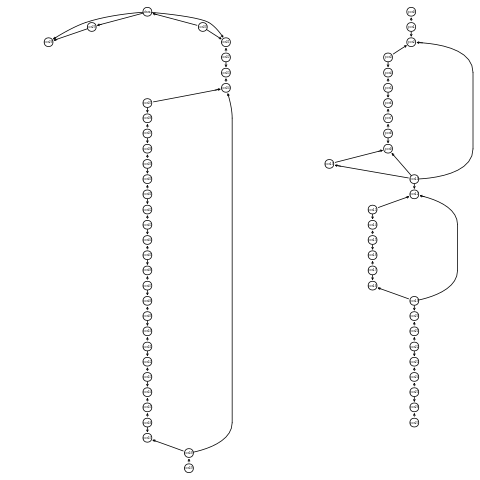

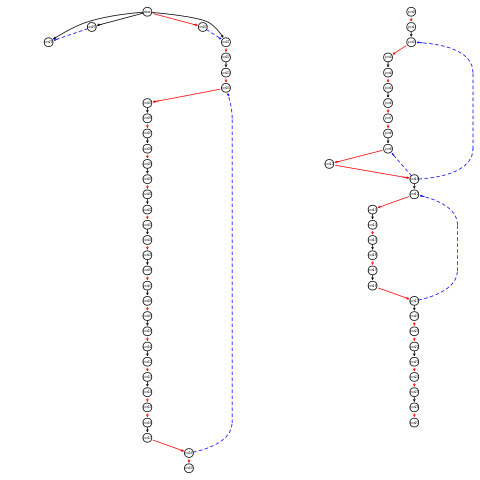

In [ ]:
%%R
graphviz.compare(iamb,mmhc)

Se tiene que ambas estructuras coinciden en 26 arcos y difieren en 72. Por lo que la similitud está en la escala con HC; ya que, MMHC y HC son las estructuras que más se parecen entre las estudiadas. Además, coinciden como era de preveer en 3 arcos con la variable clase.

**IAMB con GS**

In [ ]:
%%R

compare(iamb,gs, arcs= FALSE)

$tp
[1] 3

$fp
[1] 2

$fn
[1] 62



In [ ]:
%%R
arcos_comunes_Class(iamb,gs)

     from to


Al igual que antes con el algoritmo HC, al tener tan pocas relaciones el algoritmo GS; las diferencias con el algoritmo IAMB son prácticamente de todos los arcos. Además, no coinciden en ninguna relación con la variable clase.

**Elección de la estructura de RB**

Finalmente,se va a calcular las métricas para elegir la estructura. Se han elegido las métricas definidas por el artículo *Using Bayesian networks to discover relations between genes, environment, and disease* [1](https://biodatamining.biomedcentral.com/articles/10.1186/1756-0381-6-6).


*   *log-likelihood* (loglik)
*   *Akaike Information Criterion* (aic)
*   *the logarithm of the K2* (k2)
*   *Bayesian Information Criterion* (bic)

Para elegir la estructura, se va a crear una función para evaluar las métricas en un determinado conjunto

In [ ]:
%%R

calcular_metricas<-function(conjunto){
    
    metricas = data.frame('Algoritmos'=c('hc','mmhc','iamb','gs'))

    metricas.names = c('loglik','aic','k2','bic')

    for(i in 1:length(metricas.names)){
        metricas_aux=vector("numeric",length(metricas[['Algoritmos']]))

        metricas_aux[1]=score(hc,conjunto,type = metricas.names[i])
        metricas_aux[2]=score(mmhc,conjunto,type = metricas.names[i])
        metricas_aux[3]=score(iamb,conjunto,type = metricas.names[i])
        metricas_aux[4]=score(gs,conjunto,type = metricas.names[i])
        
        metricas[[metricas.names[i]]]=metricas_aux
    }

    return(metricas)

}

Se evaluan las métricas en los conjuntos de validación y entrenamiento. Aunque el conjunto que se usa para decidir es el conjunto de validación que no ha participado en el entrenamiento.

In [ ]:
%%R

metricasVal = calcular_metricas(val)
metricasTrain = calcular_metricas(train)

Transferimos los datos a Python para su mejor representación

In [ ]:
%R -o metricasVal -o metricasVal #transferir metrica a python
%R -o metricasTrain -o metricasTrain #transferir metrica a python

In [ ]:
metricasVal.style.highlight_max(color = 'lightgreen', axis = 0)

,Algoritmos,loglik,aic,k2,bic
1,hc,-50237.382946,-50929.382946,-51655.753168,-52850.457047
2,mmhc,-50527.272868,-51228.272868,-51956.548474,-53174.332038
3,iamb,-49739.979075,-51682.979075,-52244.343777,-56009.675761
4,gs,-52638.233160,-52904.233160,-53233.494716,-53496.565285


In [ ]:
metricasTrain.style.highlight_max(color = 'lightgreen', axis = 0)

,Algoritmos,loglik,aic,k2,bic
1,hc,-151609.635251,-152301.635251,-153396.872436,-154222.709353
2,mmhc,-152442.708837,-153143.708837,-154250.150162,-155089.768007
3,iamb,-151399.161365,-153342.161365,-154775.866343,-158736.159890
4,gs,-158037.150282,-158303.150282,-158774.627760,-159041.597841


Se aprecia con el color Verde los valores más altos. Aunque no se obtengan los mismos valores en los conjuntos de entrenamiento y validación; se obtiene el mismo resultado en el algoritmo que más veces obtiene el mejor resultado (tres de cuatro). Por lo que el algoritmo elegido será ***Hill-Climbing*** (HC).

A continuación se muestra la estructura del algoritmo HC. La variable central es la variable clase que se quiere predecir. Si se quiere ver la estructura de forma interactiva se puede usar la web de la última sección.

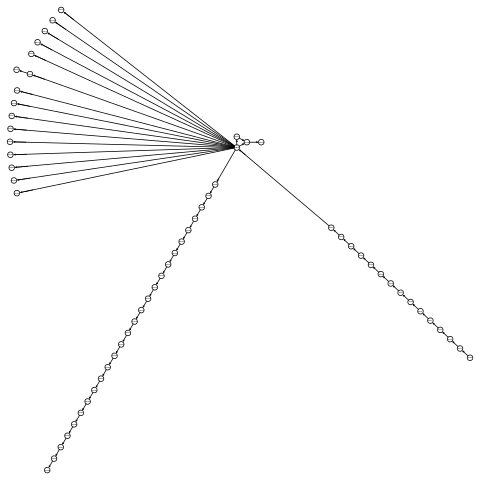

In [ ]:
%%R

graphviz.plot(hc, layout = "circo")

## Aprendizaje Distribución

Para la estimación parámetrica, se va a usar el estadístico máximo verosímil (EMV) porque es el que se ha estudiado teóricamente.


Para implementar la estimación paramétrica, se va a usar la función de bnlearn *bn.fit*. La cual estima los parámetros de la distribución de una determinada estructura, usando un determinado método. Como ya se ha comentado, el método sera el EMV ("mle") y la estructura será la aprendida con el algoritmo HC. Para estimar los parámetros se usará el conjunto de entrenamiento (*train*).

BNlearn representa las distribuciones de probabilidad condicionada (DPCs) de la distribución en formato tablas. 

In [ ]:
%%R
model = bn.fit(hc,train,method = "mle")

A continuación, se muestra la distribución aprendida. Cada DPC de la distribución de la RB es una tabla.

In [ ]:
%%R
model


  Bayesian network parameters

  Parameters of node class (multinomial distribution)

Conditional probability table:
 
     pos14
class         A         C         G         T
   EI 0.2549020 0.2539130 0.2729258 0.1788793
   IE 0.1519608 0.3286957 0.1419214 0.3081897
   N  0.5931373 0.4173913 0.5851528 0.5129310

  Parameters of node pos0 (multinomial distribution)

Conditional probability table:
         A         C         G         T 
0.2293963 0.2745407 0.2656168 0.2304462 

  Parameters of node pos1 (multinomial distribution)

Conditional probability table:
 
    pos0
pos1          A          C          G          T
   A 0.26773455 0.23518164 0.31027668 0.14350797
   C 0.21281465 0.35564054 0.21146245 0.28701595
   G 0.29061785 0.09751434 0.31027668 0.32801822
   T 0.22883295 0.31166348 0.16798419 0.24145786

  Parameters of node pos2 (multinomial distribution)

Conditional probability table:
 
    pos1
pos2         A         C         G         T
   A 0.2782609 0.2519531 0.23382

En este punto, se tiene tanto la estructura como la distribución. Por lo tanto, ya se tiene aprendida la RB sobre el conjunto de entrenamiento.

## Predicción

Ahora, se puede realizar la predicción de la variable *class* para las instancias del conjunto de comprobación (*test*). Este conjunto no ha intervenido en el proceso de estimación y por tanto es una buena forma de saber si la RB será capaz de generalizar la información aprendida.

Para analizar la bondad del modelo en el problema de clasificación sobre las etiquetas, se ha decidido implementar una función llamada *predecir* que evalúa el porcentaje de etiquetas acertadas por el modelo en un determinado conjunto. Para ello, se usa la función [predict](https://www.bnlearn.com/documentation/man/impute.html) de bnlearn. 

Con esta función se consigue la probabilidad de que se dé un hecho ante un conjunto de evidencias. Por tanto, si la evidencia es la instancia a predecir sin la variable *class*, se obtienen las probabilidades de que esa instancia pertenezca a una determinada clase. Con este hecho y la etiqueta asociada a la instancia; se puede comprobar si la predicción es correcta.

La función *predecir*, escoge la etiqueta predicha con mayor probabilidad y la compara con la etiqueta real de la instancia. Si esta etiqueta es la misma, entonces se ha acertado en la predicción. Los parámetros de la función *predecir* son:

* **modelo**. La distribución con la que se quiere predecir.
* **conjunto**. El conjunto a evaluar la predicción.
* **metodo**. Método elegido para la función *predict*. Se va a usar el método *bayes-lw*.

Para visualizar lo que se comenta, se va a calcular las probabilidades de que una instancia del conjunto test sea de una determinada clase.

In [ ]:
%%R
evidencias=subset(test,select=-c(class))
evidencias[8,]

     pos0 pos1 pos2 pos3 pos4 pos5 pos6 pos7 pos8 pos9 pos10 pos11 pos12 pos13
1987    T    G    A    C    G    C    C    C    T    C     A     A     G     G
     pos14 pos15 pos16 pos17 pos18 pos19 pos20 pos21 pos22 pos23 pos24 pos25
1987     G     C     A     C     T     G     T     G     A     G     T     C
     pos26 pos27 pos28 pos29 pos30 pos31 pos32 pos33 pos34 pos35 pos36 pos37
1987     C     C     T     G     C     C     C     A     C     C     T     G
     pos38 pos39 pos40 pos41 pos42 pos43 pos44 pos45 pos46 pos47 pos48 pos49
1987     G     G     C     C     A     G     G     C     C     C     T     G
     pos50 pos51 pos52 pos53 pos54 pos55 pos56 pos57 pos58 pos59
1987     C     C     C     C     T     T     C     T     C     T


In [ ]:
%%R
predict(model, node = "class", data = evidencias[8,], method = "bayes-lw",prob=TRUE)

[1] N
attr(,"prob")
           [,1]
EI 2.263528e-05
IE 0.000000e+00
N  9.999774e-01
Levels: EI IE N


In [ ]:
%%R
test[8,1]

[1] N
Levels: EI IE N


Se aprecia, que el modelo estima que la clase de la instancia es N con probabilidad 0.99 y la clase de la instancia es N.

A continuación se evalúa este hecho sbre todo el conjunto de test con la función *predecir* indicada anteriormente.

In [ ]:
%%R

predecir <- function(modelo,conjunto,metodo="bayes-lw") { #model es el modelo y evidence el conjunto con el que predecimos
  aciertos=0.0
  evidence <- subset(conjunto,select=-c(class))
  predicted <- predict(model, node = "class", data = evidence, method = metodo)

  for (i in 1:length(predicted)){
      if(predicted[i]==conjunto[['class']][i]){
          aciertos = aciertos + 1.0
      }
  }

  return ( aciertos/length(predicted) *100 )

}

In [ ]:
%%R

predecir(model,test,metodo="bayes-lw")

[1] 96.06299


In [ ]:
%%R

predecir(model,train,metodo="bayes-lw")

[1] 96.0105


In [ ]:
%%R

predecir(model,val,metodo="bayes-lw")

[1] 96.37795


**Matriz de Confusión**

El problema de la métrica anterior es que es susceptible a que un modelo consiga mas aciertos en la clase desbalanceada. Es decir, si el modelo fuese el modelo que constantemente devuelve la clase *N*; este modelo en este conjunto, tendría un 50% de acierto. Con la matriz de confusión calculada se evita este problema; ya que, se ven los fallos que se obtienen en cada clase. 

In [ ]:
%%R

evidence <- subset(test,select=-c(class))
predicted <- predict(model, node = "class", data = evidence, method = "bayes-lw")

In [ ]:
%R -o predicted -o predicted #transferir metrica a python

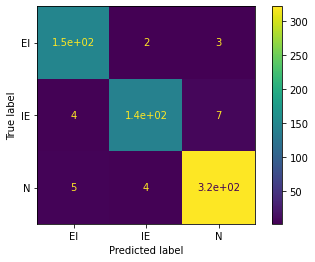

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confMatrix=confusion_matrix(test["class"], predicted,labels=['EI','IE','N'])
disp = ConfusionMatrixDisplay(confusion_matrix=confMatrix,display_labels=['EI','IE','N'])

disp.plot() 

Se observa, que las clases tienen prácticamente el mismo número de fallos, por lo que el modelo no se ha visto afectado por los datos desbalanceados. Para comprobar esto se van a evaluar dos métricas: F1 score y Recall. Se han elegido estas métricas porque funcionan bien con datos desbalanceados.

In [ ]:
from sklearn.metrics import f1_score,recall_score

f1_score(test["class"], predicted,labels=['EI','IE','N'], average='weighted') #weighted para unbalanced

0.960573362584266

In [ ]:
recall_score(test["class"], predicted,labels=['EI','IE','N'], average='weighted')

0.9606299212598425

El modelo consigue resultados buenos para todas las etiquetas, y las métricas así lo demuestran. Estos resultados son generalizables; ya que el conjunto *test* no ha intervenido en el proceso de estimación de la RB. 

# Representar Red Bayesiana Interactiva

Para representar la red bayesiana y que podamos verla voy a usar la web [edotor](https://edotor.net/) para el que necesitamos la red en formato .DOT




In [ ]:
%%R
network=iamb

In [ ]:
%%R
write.dot(network, file = "dag.dot")
cat(readLines("dag.dot"), sep = "\n")
